# ML experiment: type

Set-up:
- we aim to get a first benchmark of how good can our ML predictions be for new problems and set-ups
- we have about ~1M datapoints per experiment, which is about a 1/10 of the PLOS paper
- we will use only buildings and blocks as urban form information, but they were the most predictive set of features for height prediction
- we are using two buffer sizes, 100m and 500m
- here we have some new features that we never tried previously, and we can explore whether age/type/floors/height are predictive of each other

Procedure:
- change from regression to classification: different models, metrics, plots
- train models from binary classification (residential vs non-residential) and multi-class:
    - train 5 models with 2D geometrical features on n-1 regions, predicting on the last one, report the results
    - train 5 models with all features (includes type, age, floors, heights) on n-1 regions, predicting on the last one, report the results
- copy paste the code below for each region/experiment so that we save all the prints
- plots/analysis of the results
- report individual results and average results for each region/experiment in a table

In [102]:
# TODO: change imports

import pandas as pd
import geopandas as gpd
import numpy as np
import os 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import xgboost

In [145]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

We set the main variables. We aim to cross-validate our results using five French sub-regions 'departement' listed below.

In [27]:
path_input = r'E:\first-exp\all_age.csv'

In [30]:
region_names = ['Haute-Vienne','Hauts-de-Seine','Aisne','Orne','Pyrénées-Orientales']

In [78]:
aux_cols = ['ID','USAGE2','PREC_ALTI', 'NB_LOGTS','MAT_TOITS','MAT_MURS', 'geometry','city','departement','is_buffer','TouchesIndexes']

In [48]:
other_attributes_cols = ['USAGE1','NB_ETAGES','HAUTEUR']

The five departements are spatial distant. We will repeat an experiment where we train on 4 and predict on 5th, to see if we manage to generalize across regions.

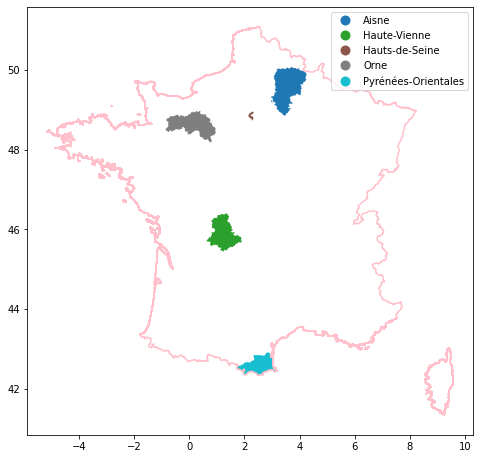

In [25]:
# dont run this cell if you dont want the map to disappear

# GDAM0=gpd.read_file(r'E:\ML_paper\Data\1-data_primary\GADM\France\gadm36_FRA_0.shp')
# GDAM2=gpd.read_file(r'E:\ML_paper\Data\1-data_primary\GADM\France\gadm36_FRA_2.shp')
# GDAM2=GDAM2[GDAM2.NAME_2.isin(region_names)]
# fig, ax = plt.subplots(figsize=(8,8))
# GDAM0.boundary.plot(ax=ax,color='pink')
# GDAM2.plot(ax=ax,column='NAME_2',legend=True)
# plt.show()

Let's import and preprocess the data.

In [79]:
# whole dataset
df_input = pd.read_csv(path_input)
len(df_input)

851843

In [80]:
# we take on region of validation
df_valid = df_input[df_input.departement==region_names[0]]
len(df_valid)

165698

In [81]:
# we use the rest for training
df_input = df_input[~df_input.index.isin(df_valid.index)]
len(df_input)

686145

In [ ]:
# TODO: adapt input for binary and multi-class classifications

## First try

In [82]:
df_input = shuffle(df_input,random_state=0)
df_valid = shuffle(df_valid,random_state=0)

In [83]:
X_train = df_input.drop(columns=aux_cols+other_attributes_cols+['USAGE1'])
y_train = df_input[['USAGE1']]

In [84]:
X_valid = df_valid.drop(columns=aux_cols+other_attributes_cols+['USAGE1'])
y_valid = df_valid[['USAGE1']]

In [85]:
print((X_train.shape,y_train.shape,X_valid.shape,y_valid.shape))

((686145, 58), (686145, 1), (165698, 58), (165698, 1))


Here are our predictors.

In [153]:
X_train.columns

Index(['FootprintArea', 'Perimeter', 'Phi', 'LongestAxisLength', 'Elongation',
       'Convexity', 'Orientation', 'Corners', 'CountTouches',
       'SharedWallLength', 'BlockLength', 'AvBlockFootprintArea',
       'StdBlockFootprintArea', 'BlockTotalFootprintArea', 'BlockPerimeter',
       'BlockLongestAxisLength', 'BlockElongation', 'BlockConvexity',
       'BlockOrientation', 'BlockCorners', 'buildings_within_buffer_500',
       'total_ft_area_within_buffer_500',
       'av_footprint_area_within_buffer_500',
       'av_elongation_within_buffer_500', 'av_convexity_within_buffer_500',
       'av_orientation_within_buffer_500',
       'std_footprint_area_within_buffer_500',
       'std_elongation_within_buffer_500', 'std_convexity_within_buffer_500',
       'std_orientation_within_buffer_500', 'buildings_within_buffer_100',
       'total_ft_area_within_buffer_100',
       'av_footprint_area_within_buffer_100',
       'av_elongation_within_buffer_100', 'av_convexity_within_buffer_100',
 

Let's train first a linear model.

In [86]:
# TODO: change to logistic regression

model = LinearRegression()

In [87]:
model.fit(X_train,y_train)

LinearRegression()

In [88]:
y_predict = model.predict(X_valid)

In [95]:
# TODO: change to classification metrics

print('MAE: {} y'.format(metrics.mean_absolute_error(y_valid,y_predict)))
print('RMSE: {} y'.format(np.sqrt(metrics.mean_squared_error(y_valid,y_predict))))
print('R2: {}'.format(metrics.r2_score(y_valid,y_predict)))

MAE: 54.40748677699175 y
RMSE: 72.02916607582374 y
R2: 0.12503714818215217


Let's now train a regression tree.

In [97]:
# TODO: change to classifier

model = xgboost.XGBRegressor()

In [98]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [99]:
y_predict = model.predict(X_valid)

In [ ]:
# TODO: new plots

In [138]:
ft_importance = pd.DataFrame.from_dict(model.get_booster().get_score(importance_type="gain"), columns=['importance'],orient='index')

In [144]:
ft_importance[0:15]

,importance
buildings_within_buffer_500,2012421.18
BlockElongation,1045971.22
BlockConvexity,756980.55
FootprintArea,980127.91
av_elongation_within_buffer_100,1227200.65
total_ft_area_within_buffer_100,526016.05
std_elongation_within_buffer_500,707499.73
StdBlockFootprintArea,306741.45
av_elongation_within_buffer_500,789066.87
total_ft_area_within_buffer_500,704159.71


## Adding the other features